In [10]:
import pandas as pd
import sqlite3
import numpy as np
from plotnine import *

# Connect to Database and Extract Dataset

In [11]:
conn = sqlite3.connect("sabs_moonshot.db")
data = pd.read_sql_query("""
SELECT smiles, fingerprint, r_avg_IC50, f_avg_IC50
FROM assays
INNER JOIN compounds ON compounds.id = assays.compound_id
WHERE assays.r_avg_IC50 != "" OR assays.f_avg_IC50 != "";
""", conn)
pd.to_numeric(data["r_avg_IC50"], errors='coerce')
pd.to_numeric(data["f_avg_IC50"], errors='coerce')
data["r_avg_IC50"] = data["r_avg_IC50"].replace("", np.NaN)
data["f_avg_IC50"] = data["f_avg_IC50"].replace("", np.NaN)
conn.close()
#data = data[data["f_avg_IC50"] < 99]
#data = data[data["r_avg_IC50"] < 99]
data

,smiles,fingerprint,r_avg_IC50,f_avg_IC50
0,N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1,0000000000000000000000000000000000000000000000...,NaN,54.272964
1,N#Cc1cccc(NC(=O)Nc2c[nH]c3ncccc23)c1,0000000000000000000000000000000000000000000000...,NaN,63.554925
2,N#Cc1cccc(NC(=O)Cc2cncc3ccccc23)c1,0000000000000000000000000000000000000000010000...,14.641091,26.680129
3,O=C(Cc1cncc2ccccc12)Nc1ccccc1,0000000000000000000000000000000000000000010000...,45.077469,57.469670
4,N#Cc1cc(Cl)cc(NC(=O)Nc2cccnc2)c1,0000000000000000000000000000000000000000000000...,NaN,99.010000
...,...,...,...,...
2430,N#CC1(CS(=O)(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5c...,0000000000000000000000000000000000000000010000...,NaN,7.793945
2431,CNC(=O)CN1CC2(CCN(c3cncc4cccc(Cl)c34)C2=O)c2cc...,0000000000000000000000000000000000000000010000...,NaN,1.674005
2432,Cc1cnn(C)c1C(=O)N1Cc2ccc(Cl)cc2C2(CCN(c3cncc4c...,0000000000000000000000000000000000000000010100...,NaN,0.682988
2433,Cc1cc(C(=O)N2Cc3ccc(Cl)cc3C3(CCN(c4cncc5ccccc4...,0000000000000000000000000000000000000000010000...,NaN,0.463982


## Create X, Y Inputs and Outputs numpy arrays

In [12]:
X = np.array([[int(c) for c in data["fingerprint"].iloc[i]] for i in range(len(data["fingerprint"]))])
Y = -np.log10(np.mean(data[["r_avg_IC50", "f_avg_IC50"]], axis=1).to_numpy())

# Perform Feature Selection

### Remove Low Variance Features

In [13]:
from sklearn.feature_selection import VarianceThreshold
sel = VarianceThreshold(threshold = 0)
X = sel.fit_transform(X)
X.shape

(2435, 2014)

### Remove Highly Correlated Features

In [14]:
X = pd.DataFrame(X)
corr_matrix = X.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
X.drop(to_drop, axis=1, inplace=True)
X = X.to_numpy()
X.shape


(2435, 2006)

### Final Datasets X and Y

In [15]:
X, Y # X is features, Y is avg IC50
np.save("classifier_data/X", X)
np.save("classifier_data/Y", Y)

/usr/local/anaconda3.7/lib/python3.7/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 17'. Pick better value with 'binwidth'.
  warn(msg.format(params['bins']), PlotnineWarning)


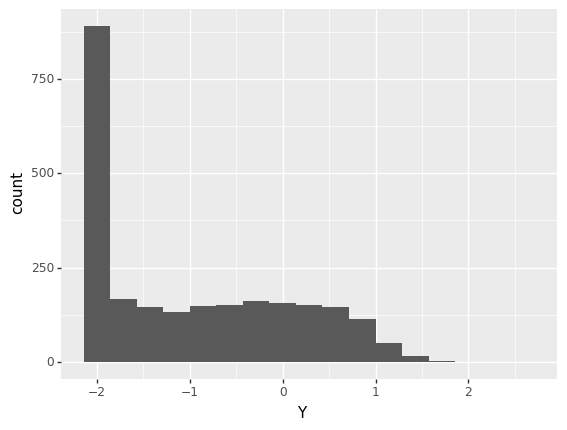

<ggplot: (8734261276197)>

In [16]:
(
    ggplot(pd.DataFrame(X, Y)) +
    geom_histogram(aes(x='Y'))
)